In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/30, Train Loss: 0.5568, Train Acc: 0.8009, Val Loss: 0.4004, Val Acc: 0.8113, Precision: 0.6582, Recall: 0.8113, F1 Score: 0.7268
Best model saved.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/30, Train Loss: 0.3068, Train Acc: 0.8365, Val Loss: 0.2787, Val Acc: 0.8113, Precision: 0.6582, Recall: 0.8113, F1 Score: 0.7268
Best model saved.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/30, Train Loss: 0.1939, Train Acc: 0.8365, Val Loss: 0.2525, Val Acc: 0.8113, Precision: 0.6582, Recall: 0.8113, F1 Score: 0.7268
Best model saved.
Epoch 4/30, Train Loss: 0.1806, Train Acc: 0.8578, Val Loss: 0.2469, Val Acc: 0.8585, Precision: 0.8583, Recall: 0.8585, F1 Score: 0.8294
Best model saved.
Epoch 5/30, Train Loss: 0.1720, Train Acc: 0.9289, Val Loss: 0.4322, Val Acc: 0.8774, Precision: 0.8718, Recall: 0.8774, F1 Score: 0.8626
Early stopping counter: 1/5
Epoch 6/30, Train Loss: 0.1639, Train Acc: 0.9526, Val Loss: 0.3042, Val Acc: 0.9151, Precision: 0.9124, Recall: 0.9151, F1 Score: 0.9102
Early stopping counter: 2/5
Epoch 7/30, Train Loss: 0.1169, Train Acc: 0.9787, Val Loss: 0.3893, Val Acc: 0.9057, Precision: 0.9066, Recall: 0.9057, F1 Score: 0.8960
Early stopping counter: 3/5
Epoch 8/30, Train Loss: 0.0885, Train Acc: 0.9787, Val Loss: 0.2957, Val Acc: 0.9340, Precision: 0.9339, Recall: 0.9340, F1 Score: 0.9302
Early stopping counter: 4/5
Epoch 9/30, Train Loss: 

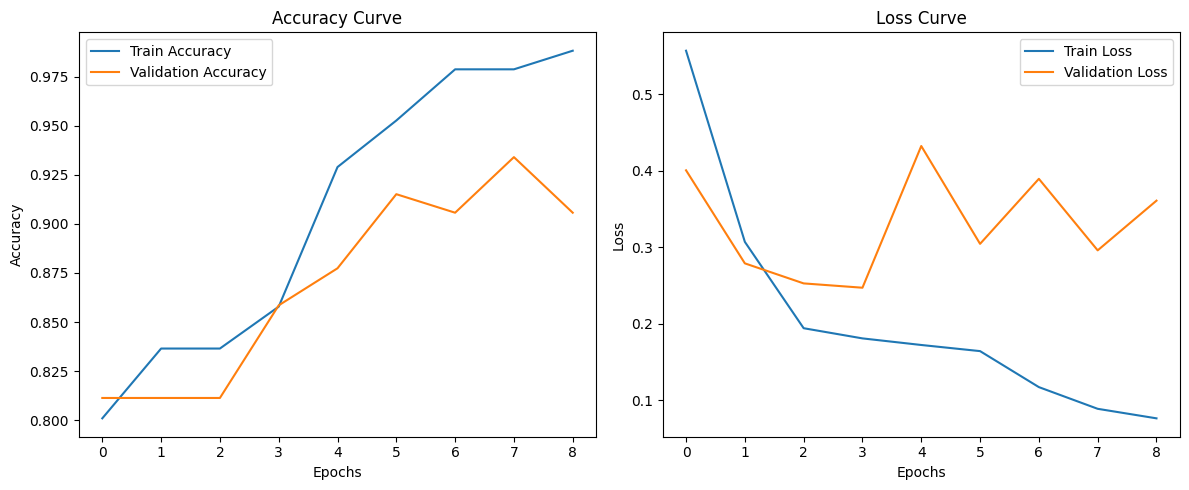

In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths
first_set_path = "/kaggle/input/histopathological/First Set"

# Hyperparameters
num_epochs = 30
batch_size = 32
learning_rate = 0.001
num_classes = 2  # Normal and OSCC
early_stop_patience = 5

# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset
train_dataset = datasets.ImageFolder(root=first_set_path, transform=transform)

# Splitting the dataset
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Load pre-trained ShuffleNet model
model = models.shufflenet_v2_x1_0(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Early stopping setup
best_val_loss = float('inf')
early_stop_counter = 0

# Training and validation loop
train_acc, val_acc = [], []
train_loss, val_loss = [], []

for epoch in range(num_epochs):
    model.train()
    total_train_loss, correct_train = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()

    train_acc.append(correct_train / len(train_dataset))
    train_loss.append(total_train_loss / len(train_loader))

    # Validation
    model.eval()
    total_val_loss, correct_val = 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    val_acc.append(correct_val / len(val_dataset))
    val_loss.append(total_val_loss / len(val_loader))

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    acc = accuracy_score(all_labels, all_preds)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, "
          f"Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Early stopping
    if val_loss[-1] < best_val_loss:
        best_val_loss = val_loss[-1]
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model.pth")  # Save the best model
        print("Best model saved.")
    else:
        early_stop_counter += 1
        print(f"Early stopping counter: {early_stop_counter}/{early_stop_patience}")

    if early_stop_counter >= early_stop_patience:
        print("Early stopping triggered. Stopping training.")
        break

# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
